In [34]:
import numpy as np
import pandas as pd
import glob
from joblib import Parallel, delayed
from tqdm import tqdm
import lightgbm as lgb

In [35]:
application = pd.read_csv('./src/application_train.csv')
# application_test = pd.read_csv('./src/application_test.csv')
# application_test doesnt contain target column, it is useless to us because even if we develop a model, we still dont know its accuracy on the training set. 

In [36]:
bureau = pd.read_csv('./src/bureau.csv')

In [37]:
bureau_balance = pd.read_csv('./src/bureau_balance.csv')

In [38]:
credit_card_balance = pd.read_csv('./src/credit_card_balance.csv')

In [39]:
installments_payments = pd.read_csv('./src/installments_payments.csv')

In [40]:
POS_CASH_balance = pd.read_csv('./src/POS_CASH_balance.csv')
previous_application = pd.read_csv('./src/previous_application.csv')

In [41]:
home_credit_columns_description = pd.read_csv('./src/HomeCredit_columns_description.csv', encoding='iso-8859-1',
                                              index_col=0)

In [42]:
# sample_submission = pd.read_csv('./src/sample_submission.csv')

# Data preprocessing

In [43]:
application.describe()

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,307511.000000,307511.000000,307511.000000,3.075110e+05,3.075110e+05,307499.000000,3.072330e+05,307511.000000,307511.000000,307511.000000,...,307511.000000,307511.000000,307511.000000,307511.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000
mean,278180.518577,0.080729,0.417052,1.687979e+05,5.990260e+05,27108.573909,5.383962e+05,0.020868,-16036.995067,63815.045904,...,0.008130,0.000595,0.000507,0.000335,0.006402,0.007000,0.034362,0.267395,0.265474,1.899974
std,102790.175348,0.272419,0.722121,2.371231e+05,4.024908e+05,14493.737315,3.694465e+05,0.013831,4363.988632,141275.766519,...,0.089798,0.024387,0.022518,0.018299,0.083849,0.110757,0.204685,0.916002,0.794056,1.869295
min,100002.000000,0.000000,0.000000,2.565000e+04,4.500000e+04,1615.500000,4.050000e+04,0.000290,-25229.000000,-17912.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,189145.500000,0.000000,0.000000,1.125000e+05,2.700000e+05,16524.000000,2.385000e+05,0.010006,-19682.000000,-2760.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,278202.000000,0.000000,0.000000,1.471500e+05,5.135310e+05,24903.000000,4.500000e+05,0.018850,-15750.000000,-1213.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,367142.500000,0.000000,1.000000,2.025000e+05,8.086500e+05,34596.000000,6.795000e+05,0.028663,-12413.000000,-289.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
max,456255.000000,1.000000,19.000000,1.170000e+08,4.050000e+06,258025.500000,4.050000e+06,0.072508,-7489.000000,365243.000000,...,1.000000,1.000000,1.000000,1.000000,4.000000,9.000000,8.000000,27.000000,261.000000,25.000000


In [44]:
# application.loc[:,['SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV']]

In [45]:
home_credit_columns_description

,Table,Row,Description,Special
1,application_{train|test}.csv,SK_ID_CURR,ID of loan in our sample,NaN
2,application_{train|test}.csv,TARGET,Target variable (1 - client with payment diffi...,NaN
5,application_{train|test}.csv,NAME_CONTRACT_TYPE,Identification if loan is cash or revolving,NaN
6,application_{train|test}.csv,CODE_GENDER,Gender of the client,NaN
7,application_{train|test}.csv,FLAG_OWN_CAR,Flag if the client owns a car,NaN
...,...,...,...,...
217,installments_payments.csv,NUM_INSTALMENT_NUMBER,On which installment we observe payment,NaN
218,installments_payments.csv,DAYS_INSTALMENT,When the installment of previous credit was su...,time only relative to the application
219,installments_payments.csv,DAYS_ENTRY_PAYMENT,When was the installments of previous credit p...,time only relative to the application
220,installments_payments.csv,AMT_INSTALMENT,What was the prescribed installment amount of ...,NaN


In [46]:
bureau

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.00,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.00,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.50,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.00,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.00,NaN,NaN,0.0,Consumer credit,-21,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1716423,259355,5057750,Active,currency 1,-44,0,-30.0,NaN,0.0,0,11250.00,11250.0,0.0,0.0,Microloan,-19,NaN
1716424,100044,5057754,Closed,currency 1,-2648,0,-2433.0,-2493.0,5476.5,0,38130.84,0.0,0.0,0.0,Consumer credit,-2493,NaN
1716425,100044,5057762,Closed,currency 1,-1809,0,-1628.0,-970.0,NaN,0,15570.00,NaN,NaN,0.0,Consumer credit,-967,NaN
1716426,246829,5057770,Closed,currency 1,-1878,0,-1513.0,-1513.0,NaN,0,36000.00,0.0,0.0,0.0,Consumer credit,-1508,NaN


the SK_ID_CURR is the unique id for each client

In [47]:
len(application)

307511

In [48]:
len(bureau)

1716428

In [49]:
len(bureau_balance)

27299925

In [50]:
len(credit_card_balance)

3840312

In [51]:
len(installments_payments)

13605401

In [52]:
len(POS_CASH_balance)

10001358

In [53]:
len(previous_application)

1670214

## merge the bureau data with bureau_balance data (Kevin)

In [54]:
status_count = bureau_balance.groupby('SK_ID_BUREAU')['STATUS'].value_counts().unstack().fillna(0)
status_count.columns = ['BUREAU_BALANCE_' + str(col_name) for col_name in status_count.columns]
status_count.reset_index(inplace=True)
month_count = bureau_balance.groupby('SK_ID_BUREAU')['MONTHS_BALANCE'].min().abs().rename('BUREAU_BALANCE_MONTH_COUNT')
status_count = status_count.merge(month_count, how='left', on='SK_ID_BUREAU')  # add 0.001 to avoid divide by 0

In [55]:
# scale the status_count by month_count
for col in status_count.columns[1:-1]:
    status_count[col] = status_count[col] / (status_count['BUREAU_BALANCE_MONTH_COUNT'] + 1.001)

In [56]:
status_count.columns

Index(['SK_ID_BUREAU', 'BUREAU_BALANCE_0', 'BUREAU_BALANCE_1',
       'BUREAU_BALANCE_2', 'BUREAU_BALANCE_3', 'BUREAU_BALANCE_4',
       'BUREAU_BALANCE_5', 'BUREAU_BALANCE_C', 'BUREAU_BALANCE_X',
       'BUREAU_BALANCE_MONTH_COUNT'],
      dtype='object')

In [57]:
bureau = bureau.merge(status_count, how='left', on='SK_ID_BUREAU')

In [58]:
bureau.describe()

,SK_ID_CURR,SK_ID_BUREAU,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,...,AMT_ANNUITY,BUREAU_BALANCE_0,BUREAU_BALANCE_1,BUREAU_BALANCE_2,BUREAU_BALANCE_3,BUREAU_BALANCE_4,BUREAU_BALANCE_5,BUREAU_BALANCE_C,BUREAU_BALANCE_X,BUREAU_BALANCE_MONTH_COUNT
count,1.716428e+06,1.716428e+06,1.716428e+06,1.716428e+06,1.610875e+06,1.082775e+06,5.919400e+05,1.716428e+06,1.716415e+06,1.458759e+06,...,4.896370e+05,774354.000000,774354.000000,774354.000000,774354.000000,774354.000000,774354.000000,774354.000000,774354.000000,774354.000000
mean,2.782149e+05,5.924434e+06,-1.142108e+03,8.181666e-01,5.105174e+02,-1.017437e+03,3.825418e+03,6.410406e-03,3.549946e+05,1.370851e+05,...,1.571276e+04,0.351976,0.009966,0.000683,0.000236,0.000154,0.001295,0.327617,0.192275,36.288669
std,1.029386e+05,5.322657e+05,7.951649e+02,3.654443e+01,4.994220e+03,7.140106e+02,2.060316e+05,9.622391e-02,1.149811e+06,6.774011e+05,...,3.258269e+05,0.328245,0.042879,0.007975,0.003747,0.002875,0.024694,0.358784,0.320677,25.449736
min,1.000010e+05,5.000000e+06,-2.922000e+03,0.000000e+00,-4.206000e+04,-4.202300e+04,0.000000e+00,0.000000e+00,0.000000e+00,-4.705600e+06,...,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.888668e+05,5.463954e+06,-1.666000e+03,0.000000e+00,-1.138000e+03,-1.489000e+03,0.000000e+00,0.000000e+00,5.130000e+04,0.000000e+00,...,0.000000e+00,0.079545,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,15.000000
50%,2.780550e+05,5.926304e+06,-9.870000e+02,0.000000e+00,-3.300000e+02,-8.970000e+02,0.000000e+00,0.000000e+00,1.255185e+05,0.000000e+00,...,0.000000e+00,0.239990,0.000000,0.000000,0.000000,0.000000,0.000000,0.160492,0.019607,31.000000
75%,3.674260e+05,6.385681e+06,-4.740000e+02,0.000000e+00,4.740000e+02,-4.250000e+02,0.000000e+00,0.000000e+00,3.150000e+05,4.015350e+04,...,1.350000e+04,0.580240,0.000000,0.000000,0.000000,0.000000,0.000000,0.692281,0.230751,53.000000
max,4.562550e+05,6.843457e+06,0.000000e+00,2.792000e+03,3.119900e+04,0.000000e+00,1.159872e+08,9.000000e+00,5.850000e+08,1.701000e+08,...,1.184534e+08,0.999989,0.999923,0.714184,0.399920,0.499875,0.999974,0.999990,0.999990,96.000000


## Cleaning bureau data (Kevin)

In [59]:
# print number of unique item in each column
for col in bureau.columns:
    print(col, 'Unique item:', len(bureau[col].unique()), 'NA:', len(bureau.loc[bureau[col].isnull()]), 'value=0:',
          len(bureau.loc[bureau[col] == 0]))

SK_ID_CURR Unique item: 305811 NA: 0 value=0: 0
SK_ID_BUREAU Unique item: 1716428 NA: 0 value=0: 0
CREDIT_ACTIVE Unique item: 4 NA: 0 value=0: 0
CREDIT_CURRENCY Unique item: 4 NA: 0 value=0: 0
DAYS_CREDIT Unique item: 2923 NA: 0 value=0: 25
CREDIT_DAY_OVERDUE Unique item: 942 NA: 0 value=0: 1712211
DAYS_CREDIT_ENDDATE Unique item: 14097 NA: 105553 value=0: 883
DAYS_ENDDATE_FACT Unique item: 2918 NA: 633653 value=0: 64
AMT_CREDIT_MAX_OVERDUE Unique item: 68252 NA: 1124488 value=0: 470650
CNT_CREDIT_PROLONG Unique item: 10 NA: 0 value=0: 1707314
AMT_CREDIT_SUM Unique item: 236709 NA: 13 value=0: 66582
AMT_CREDIT_SUM_DEBT Unique item: 226538 NA: 257669 value=0: 1016434
AMT_CREDIT_SUM_LIMIT Unique item: 51727 NA: 591780 value=0: 1050142
AMT_CREDIT_SUM_OVERDUE Unique item: 1616 NA: 0 value=0: 1712270
CREDIT_TYPE Unique item: 15 NA: 0 value=0: 0
DAYS_CREDIT_UPDATE Unique item: 2982 NA: 0 value=0: 605
AMT_ANNUITY Unique item: 40322 NA: 1226791 value=0: 256915
BUREAU_BALANCE_0 Unique item: 463

In [60]:
# def aggregate_do_nothing(bureau, col):
#     res = bureau[col]
#     return res.reindex(application['SK_ID_CURR']).fillna(0).rename('BUREAU_' + col)

In [61]:
def aggregate_count(bureau, col,name):
    # res = bureau[bureau['SK_ID_CURR'].isin(application['SK_ID_CURR'])]
    # res = res.groupby('SK_ID_CURR')[col].count()
    res = bureau.groupby('SK_ID_CURR')[col].count()
    return res.reindex(application['SK_ID_CURR']).fillna(0).rename(name+'_' + col + '_COUNT')

In [62]:
def aggregate_categorical(df, col,name):
    # res = bureau[bureau['SK_ID_CURR'].isin(application['SK_ID_CURR'])]
    # res = res.groupby('SK_ID_CURR')[col].value_counts().unstack()
    res = df.groupby('SK_ID_CURR')[col].value_counts().unstack()
    res = res.reindex(application['SK_ID_CURR']).fillna(0)
    res.columns = [name+'_' + col + '_' + str(col_name) for col_name in res.columns]
    return res

In [63]:
def aggregate_avg_max_min_std_skw(df, col,name):
    # res = bureau[bureau['SK_ID_CURR'].isin(application['SK_ID_CURR'])]
    # res = res.groupby('SK_ID_CURR')[col].agg(['mean', 'max', 'min', 'std', 'skew'])
    res = df.groupby('SK_ID_CURR')[col].agg(['mean', 'max', 'min', 'std', 'skew'])
    res = res.reindex(application['SK_ID_CURR']).fillna(0)
    res.columns = [name+'_' + col + '_' + col_name for col_name in res.columns]
    return res

In [64]:
def aggregate_avg_max_min_std_skw_nan_count(df, col,name):
    res = df.groupby('SK_ID_CURR')[col].agg(['mean', 'max', 'min', 'std', 'skew'])
    # count the number of nan
    res['nan_count'] = df.groupby('SK_ID_CURR')[col].apply(lambda x: x.isnull().sum())
    res = res.reindex(application['SK_ID_CURR']).fillna(0)
    res.columns = [name+'_' + col + '_' + col_name for col_name in res.columns]
    
    return res

In [65]:
bureau_agg_dic = {'SK_ID_BUREAU': 'aggregate_count',
                  'CREDIT_ACTIVE': 'aggregate_categorical',
                  'CREDIT_CURRENCY': 'aggregate_categorical',
                  'DAYS_CREDIT': 'aggregate_avg_max_min_std_skw',
                  'CREDIT_DAY_OVERDUE': 'aggregate_avg_max_min_std_skw',
                  'DAYS_CREDIT_ENDDATE': 'aggregate_avg_max_min_std_skw_nan_count',
                  'DAYS_ENDDATE_FACT': 'aggregate_avg_max_min_std_skw_nan_count',
                  'AMT_CREDIT_MAX_OVERDUE': 'aggregate_avg_max_min_std_skw_nan_count',
                  'CNT_CREDIT_PROLONG': 'aggregate_avg_max_min_std_skw',
                  'AMT_CREDIT_SUM': 'aggregate_avg_max_min_std_skw',
                  'AMT_CREDIT_SUM_DEBT': 'aggregate_avg_max_min_std_skw_nan_count',
                  'AMT_CREDIT_SUM_LIMIT': 'aggregate_avg_max_min_std_skw_nan_count',
                  'AMT_CREDIT_SUM_OVERDUE': 'aggregate_avg_max_min_std_skw',
                  'DAYS_CREDIT_UPDATE': 'aggregate_avg_max_min_std_skw',
                  'AMT_ANNUITY': 'aggregate_avg_max_min_std_skw_nan_count',
                  'BUREAU_BALANCE_0': 'aggregate_avg_max_min_std_skw',
                  'BUREAU_BALANCE_1': 'aggregate_avg_max_min_std_skw',
                  'BUREAU_BALANCE_2': 'aggregate_avg_max_min_std_skw',
                  'BUREAU_BALANCE_3': 'aggregate_avg_max_min_std_skw',
                  'BUREAU_BALANCE_4': 'aggregate_avg_max_min_std_skw',
                  'BUREAU_BALANCE_5': 'aggregate_avg_max_min_std_skw',
                  'BUREAU_BALANCE_C': 'aggregate_avg_max_min_std_skw',
                  'BUREAU_BALANCE_X': 'aggregate_avg_max_min_std_skw',
                  'BUREAU_BALANCE_MONTH_COUNT': 'aggregate_avg_max_min_std_skw'}

In [67]:
# parallel processing
bureau_merging_result = Parallel(n_jobs=4)(
    delayed(eval(bureau_agg_dic[col]))(bureau[bureau['SK_ID_CURR'].isin(application['SK_ID_CURR'])], col,'BUREAU') for col in
    bureau_agg_dic.keys())  # 6min

In [68]:
# merge all the result on SK_ID_CURR
bureau_merging_result = pd.concat(bureau_merging_result, axis=1)

## Cleaning POS Cash data (Grace)

In [69]:
# count for how many credit cart one have
def POS_CASH_count(POS_CASH_balance):
    return POS_CASH_balance.groupby('SK_ID_CURR')['SK_ID_PREV'].count().rename('POS_CASH_SK_ID_PREV_COUNT').reindex(
        application['SK_ID_CURR']).fillna(0)

In [70]:
def contract_status(POS_CASH_balance):
    # one hot encode the NAME_CONTRACT_STATUS
    dum = pd.get_dummies(POS_CASH_balance['NAME_CONTRACT_STATUS'])
    for col in dum:
        dum[col] = dum[col] * (1 - POS_CASH_balance['CNT_INSTALMENT_FUTURE'] / POS_CASH_balance['CNT_INSTALMENT'])
    dum.columns = ['POS_CASH_' + str(col_name) for col_name in dum.columns]
    return POS_CASH_balance.loc[:, ['SK_ID_PREV', 'SK_ID_CURR', ]].join(dum).groupby(
        ['SK_ID_CURR', 'SK_ID_PREV']).max().groupby(
        'SK_ID_CURR').mean().reindex(application['SK_ID_CURR']).fillna(0)

In [71]:
def earliest_starting(POS_CASH_balance):
    return POS_CASH_balance.groupby(['SK_ID_CURR', 'SK_ID_PREV'])['MONTHS_BALANCE'].min().abs().groupby(
        'SK_ID_CURR').mean().reindex(application['SK_ID_CURR']).fillna(0).rename('POS_CASH_EARLIEST_STARTING')


def latest_starting(POS_CASH_balance):
    return POS_CASH_balance.groupby(['SK_ID_CURR', 'SK_ID_PREV'])['MONTHS_BALANCE'].max().abs().groupby(
        'SK_ID_CURR').mean().reindex(application['SK_ID_CURR']).fillna(0).rename('POS_CASH_LATEST_STARTING')

In [72]:
def cnt_installment_min_max_skew_count(POS_CASH_balance):
    res = POS_CASH_balance.groupby(['SK_ID_CURR', 'SK_ID_PREV'])['CNT_INSTALMENT'].first()
    res = res.groupby('SK_ID_CURR').agg(['min', 'max', 'skew', 'count'])
    return res.reindex(application['SK_ID_CURR']).fillna(0).rename(columns={'min': 'POS_CASH_CNT_INSTALMENT_MIN',
                                                                            'max': 'POS_CASH_CNT_INSTALMENT_MAX',
                                                                            'skew': 'POS_CASH_CNT_INSTALMENT_SKEW',
                                                                            'count': 'POS_CASH_CNT_INSTALMENT_COUNT'})

In [73]:
def max_col_min_max_avg_skew_count(POS_CASH_balance, col):
    tmp = POS_CASH_balance.groupby(['SK_ID_PREV', 'SK_ID_CURR'])[col].max()
    res = tmp.groupby('SK_ID_CURR').agg(['min', 'max', 'mean', 'skew'])
    res['nonzero_count'] = tmp.groupby('SK_ID_CURR').apply(lambda x: (x != 0).sum())
    return res.reindex(application['SK_ID_CURR']).fillna(0).rename(columns={'min': 'POS_CASH_MAX_' + col + '_MIN',
                                                                            'max': 'POS_CASH_MAX_' + col + '_MAX',
                                                                            'mean': 'POS_CASH_MAX_' + col + '_MEAN',
                                                                            'skew': 'POS_CASH_MAX_' + col + '_SKEW',
                                                                            'nonzero_count': 'POS_CASH_MAX_' + col + '_NON_0_COUNT'})

In [76]:
pos_cash_balance_function_list = [POS_CASH_count,
                                  contract_status,
                                  earliest_starting,
                                  latest_starting,
                                  cnt_installment_min_max_skew_count]
max_col_process_list = ['SK_DPD', 'SK_DPD_DEF']
POS_CASH_balance_merging_res = pd.concat([func(POS_CASH_balance) for func in tqdm(pos_cash_balance_function_list)]
                                         +[max_col_min_max_avg_skew_count(POS_CASH_balance,col_name) for col_name in tqdm(max_col_process_list)], axis=1)



  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:00<00:02,  1.64it/s]

 40%|████      | 2/5 [00:09<00:16,  5.50s/it]

 60%|██████    | 3/5 [00:11<00:08,  4.01s/it]

 80%|████████  | 4/5 [00:13<00:03,  3.28s/it]

100%|██████████| 5/5 [01:20<00:00, 16.14s/it]


  0%|          | 0/2 [00:00<?, ?it/s]

 50%|█████     | 1/2 [02:20<02:20, 140.59s/it]

100%|██████████| 2/2 [04:49<00:00, 144.90s/it]


In [77]:
POS_CASH_balance_merging_res.shape

(307511, 26)

## Cleaning Credit card data (Evelyne)

In [78]:
# count for how many credit cart one have
def prev_count(df:pd.DataFrame,col:str,name:str):
    return df.groupby('SK_ID_CURR')[col].count().rename(f"{name}_{col}_COUNT").reindex(
        application['SK_ID_CURR']).fillna(0)

In [79]:
def prev_aggregate_categorical(df, col,name):
    """first do value counts at previous id level, then do the same transformation at current id level"""
    res = pd.get_dummies(df.groupby(['SK_ID_CURR', 'SK_ID_PREV'])[col].value_counts().unstack().fillna(0))
    # aggregate by sum
    res = res.groupby('SK_ID_CURR').sum()
    res.columns = [name+'_'+col+'_'+str(col_name) for col_name in res.columns]
    return res.reindex(application['SK_ID_CURR']).fillna(0)

In [80]:
def prev_aggregate_max_sum(df, col,name):
    """first do max at previous id level, then do the sum at current id level"""
    res = df.groupby(['SK_ID_CURR', 'SK_ID_PREV'])[col].max()
    res = res.groupby('SK_ID_CURR').sum()
    res.columns = [name+'_'+col+'_MAX_SUM']
    return res.reindex(application['SK_ID_CURR']).fillna(0)

In [81]:
def prev_aggregate_sum_mean_min_max(df, col,name):
    """first do sum mean min max at previous id level, then do the same transformation at current id level"""
    res = df.groupby(['SK_ID_CURR', 'SK_ID_PREV'])[col].agg(['sum', 'mean', 'min', 'max']).reset_index()
    res = res.groupby('SK_ID_CURR').agg({'sum': 'sum', 'mean': 'mean', 'min': 'min', 'max': 'max'})
    res.columns = [name+'_'+col+'_'+col_name for col_name in res.columns]
    return res.reindex(application['SK_ID_CURR']).fillna(0)

In [82]:
def prev_aggregate_sum_mean_min_max_zero_count(creditcard, col,name):
    """first do min max sum zero count at previous id level, then do the same transformation at current id level"""
    res = creditcard.groupby(['SK_ID_CURR', 'SK_ID_PREV'])[col].agg(['min', 'max', 'sum','mean'])
    res['zero_count'] = creditcard.groupby(['SK_ID_CURR', 'SK_ID_PREV'])[col].apply(lambda x: (x == 0).sum())
    res = res.groupby('SK_ID_CURR').agg({'min': 'min', 'max': 'max', 'sum': 'sum', 'mean':'mean','zero_count': 'mean'})
    res.columns = [name+'_'+col+'_'+col_name for col_name in res.columns]
    return res.reindex(application['SK_ID_CURR']).fillna(0)


In [83]:
def prev_aggregate_max_col_min_max_avg_skew_count(df, col,name):
    tmp = df.groupby(['SK_ID_PREV', 'SK_ID_CURR'])[col].max()
    res = tmp.groupby('SK_ID_CURR').agg(['min', 'max', 'mean', 'skew'])
    res['nonzero_count'] = tmp.groupby('SK_ID_CURR').apply(lambda x: (x != 0).sum())
    return res.reindex(application['SK_ID_CURR']).fillna(0).rename(columns={'min': name+'_MAX_' + col + '_MIN',
                                                                            'max': name+'_MAX_' + col + '_MAX',
                                                                            'mean': name+'_MAX_' + col + '_MEAN',
                                                                            'skew': name+'_MAX_' + col + '_SKEW',
                                                                            'nonzero_count': name+'_MAX_' + col + '_NON_0_COUNT'})

In [84]:
cc_aggregate_dic={
    'SK_ID_PREV':'prev_count',
    'AMT_BALANCE':'prev_aggregate_sum_mean_min_max',# take transformation at card level then same transformation for current id
    'AMT_CREDIT_LIMIT_ACTUAL':'prev_aggregate_max_sum',# take max at card level then sum for current id
    'AMT_DRAWINGS_ATM_CURRENT':'prev_aggregate_sum_mean_min_max_zero_count',# count the number of 0 atm drawings
    'AMT_DRAWINGS_CURRENT':'prev_aggregate_sum_mean_min_max_zero_count',# count the number of 0 drawings
    'AMT_DRAWINGS_POS_CURRENT':'prev_aggregate_sum_mean_min_max_zero_count',# count the number of 0 pos drawings
    'AMT_DRAWINGS_OTHER_CURRENT':'prev_aggregate_sum_mean_min_max_zero_count',# count the number of 0 other drawings
    'AMT_INST_MIN_REGULARITY':'prev_aggregate_sum_mean_min_max_zero_count',# count the number of 0 for not needing to pay installment
    'AMT_PAYMENT_CURRENT':'prev_aggregate_max_sum',# take the max then sum among cards. instant payment ability
    'AMT_PAYMENT_TOTAL_CURRENT':'prev_aggregate_max_sum',# take the max then sum among cards. total payment ability
    'AMT_RECEIVABLE_PRINCIPAL':'prev_aggregate_sum_mean_min_max',# take transformation at card level then same transformation for current id
    'AMT_RECIVABLE':'prev_aggregate_sum_mean_min_max',# take transformation at card level then same transformation for current id
    'AMT_TOTAL_RECEIVABLE':'prev_aggregate_sum_mean_min_max',# take transformation at card level then same transformation for current id
    'CNT_DRAWINGS_ATM_CURRENT':'prev_aggregate_max_sum',# take the max then sum among cards. max atm drawings
    'CNT_DRAWINGS_CURRENT':'prev_aggregate_max_sum',# take the max then sum among cards. max drawings
    'CNT_DRAWINGS_POS_CURRENT':'prev_aggregate_max_sum',# take the max then sum among cards. max pos drawings
    'CNT_INSTALMENT_MATURE_CUM':'prev_aggregate_max_sum',# take the max then sum among cards. max installment mature cum
    'NAME_CONTRACT_STATUS':'prev_aggregate_categorical',# take value counts at card level then same transformation for current id
    'SK_DPD':'prev_aggregate_max_col_min_max_avg_skew_count',# count the number of 0 dpd
    'SK_DPD_DEF':'prev_aggregate_max_col_min_max_avg_skew_count'# count the number of 0 dpd def
}

In [85]:
credit_card_balance_merging_res = Parallel(n_jobs=4)(
    delayed(eval(cc_aggregate_dic[col]))(credit_card_balance, col,'CC') for col in tqdm(cc_aggregate_dic.keys()))



  0%|          | 0/20 [00:00<?, ?it/s]

 40%|████      | 8/20 [00:03<00:05,  2.34it/s]

 60%|██████    | 12/20 [00:35<00:28,  3.55s/it]

 80%|████████  | 16/20 [00:38<00:10,  2.53s/it]

100%|██████████| 20/20 [00:41<00:00,  2.10s/it]


In [86]:
credit_card_balance_merging_res = pd.concat(credit_card_balance_merging_res, axis=1)


In [87]:
credit_card_balance_merging_res.shape

(307511, 66)

## Cleaning Installment data (Kai)

In [88]:
def prev_aggregate_nunique(df, col,name):
    res = df.groupby('SK_ID_CURR')[col].nunique()
    return res.reindex(application['SK_ID_CURR']).fillna(0).rename(name+'_'+col+'_nunique')

In [89]:
def prev_aggregate_diff_sum_mean_min_max_zero_larger_count(df, col1,col2,name):
    res = df.loc[:,['SK_ID_CURR','SK_ID_PREV']].copy()
    res['diff']=df[col1]-df[col2]
    res['zero_larger']=res['diff'].apply(lambda x: 1 if x>=0 else 0)
    res = res.groupby(['SK_ID_CURR','SK_ID_PREV']).agg({'diff':['sum','mean','min','max','skew'],'zero_larger':'sum'})
    res.columns = res.columns.get_level_values(0)+'_'+res.columns.get_level_values(1)
    res = res.groupby('SK_ID_CURR').agg({'diff_sum':'sum','diff_mean':'mean','diff_min':'min','diff_max':'max','diff_skew':'skew','zero_larger_sum':'sum'})
    res.columns = [name+'_'+col1+'_'+col2+'_'+col_name for col_name in res.columns]
    return res.reindex(application['SK_ID_CURR']).fillna(0)

In [90]:
# prev_aggregate_diff_sum_mean_min_max_zero_larger_count(installments_payments,'DAYS_INSTALMENT','DAYS_ENTRY_PAYMENT','INS')

In [91]:
ins_aggregate_dic={
    'SK_ID_PREV':'prev_count',
    'NUM_INSTALMENT_VERSION':'prev_aggregate_nunique',
    'DAYS_INSTALMENT':'prev_aggregate_sum_mean_min_max_zero_count',
    'DAYS_ENTRY_PAYMENT':'prev_aggregate_sum_mean_min_max_zero_count',
    'AMT_INSTALMENT':'prev_aggregate_sum_mean_min_max',# there is no 0 installment
    'AMT_PAYMENT':'prev_aggregate_sum_mean_min_max',# there is no 0 installment
}
ins_aggregate_diff_dic={
    'DAYS_INSTALMENT':'DAYS_ENTRY_PAYMENT',
    'AMT_INSTALMENT':'AMT_PAYMENT',
}

In [92]:
installments_payments_merging_res = Parallel(n_jobs=4)(
    delayed(eval(ins_aggregate_dic[col]))(installments_payments, col,'INS') for col in tqdm(ins_aggregate_dic.keys()))
installments_payments_merging_res+=Parallel(n_jobs=4)(
    delayed(prev_aggregate_diff_sum_mean_min_max_zero_larger_count)(installments_payments, col1,col2,'INS') for col1,col2 in tqdm(ins_aggregate_diff_dic.items()))



100%|██████████| 6/6 [00:00<00:00, 2999.86it/s]


100%|██████████| 2/2 [00:00<00:00, 2004.45it/s]


In [93]:
installments_payments_merging_res = pd.concat(installments_payments_merging_res, axis=1)

In [94]:
installments_payments_merging_res.shape

(307511, 32)

## Cleaning Previous application data (Nicola)

In [95]:
def prev_aggregate_min_max_sum_mean_NA_count(df, col,name):
    if 'DAYS' in col:
        # fixing the na as 365243 problem
        res = df.loc[:,['SK_ID_CURR','SK_ID_PREV',col]].copy()
        res = res.replace(365243,np.nan)
    else:
        res = df.loc[:,['SK_ID_CURR','SK_ID_PREV',col]].copy()
    res = res.groupby(['SK_ID_CURR', 'SK_ID_PREV'])[col].agg(['min', 'max', 'sum', 'mean'])
    res['NA_count'] = df.groupby(['SK_ID_CURR', 'SK_ID_PREV'])[col].apply(lambda x: x.isnull().sum())
    res = res.groupby('SK_ID_CURR').agg({'min': 'min', 'max': 'max', 'sum': 'sum', 'mean': 'mean', 'NA_count': 'mean'})
    res.columns = [name+'_'+col+'_'+col_name for col_name in res.columns]
    return res.reindex(application['SK_ID_CURR']).fillna(0)

In [96]:
def prev_aggregate_workday_weekend(df, col,name):
    res = pd.DataFrame(df.loc[:,'SK_ID_CURR']).join(pd.get_dummies(df[col].apply(lambda x: 'Workday' if x in ['MONDAY','TUESDAY','WEDNESDAY','THURSDAY','FRIDAY'] else 'Weekend')))
    res = res.groupby('SK_ID_CURR').sum()
    return res.reindex(application['SK_ID_CURR']).fillna(0).rename(columns={0:name+'_'+col+'_Weekend',1:name+'_'+col+'_Workday'})

In [97]:
def prev_aggregate_hours_of_day(df, col,name):
    res = pd.DataFrame(df.loc[:,'SK_ID_CURR']).join(pd.get_dummies(df[col].apply(lambda x: 'morning' if x>12 else 'afternoon')))
    res = res.groupby('SK_ID_CURR').sum()
    return res.reindex(application['SK_ID_CURR']).fillna(0).rename(columns={0:name+'_'+col+'_afternoon',1:name+'_'+col+'_morning'})    

In [98]:
prev_app_aggregate_dic={
    'SK_ID_PREV':'prev_count',
    'NAME_CONTRACT_TYPE':'prev_aggregate_categorical',
    'AMT_ANNUITY':'prev_aggregate_sum_mean_min_max',
    'AMT_APPLICATION':'prev_aggregate_sum_mean_min_max',
    'AMT_CREDIT':'prev_aggregate_sum_mean_min_max',
    'AMT_DOWN_PAYMENT':'prev_aggregate_min_max_sum_mean_NA_count',
    'AMT_GOODS_PRICE':'prev_aggregate_sum_mean_min_max',
    'WEEKDAY_APPR_PROCESS_START':'prev_aggregate_workday_weekend',
    'HOUR_APPR_PROCESS_START':'prev_aggregate_hours_of_day',
    'FLAG_LAST_APPL_PER_CONTRACT':'prev_aggregate_categorical',
    # 'NFLAG_LAST_APPL_IN_DAY':'prev_aggregate_categorical',# we dont want this: error in system, 3% difference
    'RATE_DOWN_PAYMENT':'prev_aggregate_min_max_sum_mean_NA_count',
    'RATE_INTEREST_PRIMARY':'prev_aggregate_min_max_sum_mean_NA_count',
    'RATE_INTEREST_PRIVILEGED':'prev_aggregate_min_max_sum_mean_NA_count',
    'NAME_CASH_LOAN_PURPOSE':'prev_aggregate_categorical',
    'NAME_CONTRACT_STATUS':'prev_aggregate_categorical',
    'DAYS_DECISION':'prev_aggregate_min_max_sum_mean_NA_count',
    'NAME_PAYMENT_TYPE':'prev_aggregate_categorical',
    'CODE_REJECT_REASON':'prev_aggregate_categorical',
    'NAME_TYPE_SUITE':'prev_aggregate_categorical',
    'NAME_CLIENT_TYPE':'prev_aggregate_categorical',
    'NAME_GOODS_CATEGORY':'prev_aggregate_categorical',
    'NAME_PORTFOLIO':'prev_aggregate_categorical',
    'NAME_PRODUCT_TYPE':'prev_aggregate_categorical',
    'CHANNEL_TYPE':'prev_aggregate_categorical',
    'SELLERPLACE_AREA':'prev_aggregate_sum_mean_min_max',
    'NAME_SELLER_INDUSTRY':'prev_aggregate_categorical',
    'CNT_PAYMENT':'prev_aggregate_sum_mean_min_max',
    'NAME_YIELD_GROUP':'prev_aggregate_categorical',
    'PRODUCT_COMBINATION':'prev_aggregate_categorical',
    'DAYS_FIRST_DRAWING':'prev_aggregate_min_max_sum_mean_NA_count',
    'DAYS_FIRST_DUE':'prev_aggregate_min_max_sum_mean_NA_count',
    'DAYS_LAST_DUE_1ST_VERSION':'prev_aggregate_min_max_sum_mean_NA_count',
    'DAYS_LAST_DUE':'prev_aggregate_min_max_sum_mean_NA_count',
    'DAYS_TERMINATION':'prev_aggregate_min_max_sum_mean_NA_count',
    'NFLAG_INSURED_ON_APPROVAL':'prev_aggregate_categorical',
}
prev_app_aggregate_diff_dic={
    'AMT_APPLICATION':'AMT_CREDIT',
    'AMT_APPLICATION':'AMT_GOODS_PRICE',
    
}

In [99]:
previous_application_merging_res = Parallel(n_jobs=4)(
    delayed(eval(prev_app_aggregate_dic[col]))(previous_application, col,'PREV_APP') for col in tqdm(prev_app_aggregate_dic.keys()))
previous_application_merging_res+=Parallel(n_jobs=4)(
    delayed(prev_aggregate_diff_sum_mean_min_max_zero_larger_count)(previous_application, col1,col2,'PREV_APP') for col1,col2 in tqdm(prev_app_aggregate_diff_dic.items()))



  0%|          | 0/35 [00:00<?, ?it/s]

 23%|██▎       | 8/35 [00:05<00:19,  1.40it/s]

 34%|███▍      | 12/35 [00:15<00:34,  1.48s/it]

 46%|████▌     | 16/35 [00:27<00:37,  1.98s/it]

 57%|█████▋    | 20/35 [07:08<09:02, 36.16s/it]

 69%|██████▊   | 24/35 [07:20<04:36, 25.18s/it]

 80%|████████  | 28/35 [07:30<02:05, 17.89s/it]

 83%|████████▎ | 29/35 [07:32<01:37, 16.24s/it]

100%|██████████| 35/35 [07:42<00:00, 13.22s/it]


100%|██████████| 1/1 [00:00<00:00, 1001.51it/s]


In [100]:
previous_application_merging_res = pd.concat(previous_application_merging_res, axis=1)

In [101]:
previous_application_merging_res.shape

(307511, 223)

## Cleaning Application data (Kevin)

In [179]:
application

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,456251,0,Cash loans,M,N,N,0,157500.0,254700.0,27558.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
307507,456252,0,Cash loans,F,N,Y,0,72000.0,269550.0,12001.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
307508,456253,0,Cash loans,F,N,Y,0,153000.0,677664.0,29979.0,...,0,0,0,0,1.0,0.0,0.0,1.0,0.0,1.0
307509,456254,1,Cash loans,F,N,Y,0,171000.0,370107.0,20205.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [180]:
def aggregate_flag(df, col,name):
    """ONLY use for binary flag, transfer to 1 and 0"""
    assert len(df[col].unique()) == 2
    one_name = df[col].unique()[0]
    res = df.loc[:, ['SK_ID_CURR', col]].copy()
    res[col] = res[col].apply(lambda x: 1 if x == one_name else 0)
    return res.set_index('SK_ID_CURR').rename(columns={col: name+'_'+col})

In [181]:
def do_nothing(df, col,name):
    res = df.loc[:, ['SK_ID_CURR', col]].copy()
    if 'DAYS' in col:
        res[col].replace(365243,np.nan,inplace=True)
        res[col].replace(0,np.nan,inplace=True)
        res[name+'_'+col+'_NAN_FLAG'] = res[col].apply(lambda x: 1 if np.isnan(x) else 0)
    res[col]=res[col].fillna(0)
    res.rename(columns={col: name+'_'+col},inplace=True)
    
    return res.set_index('SK_ID_CURR')

In [182]:
def aggregate_workday_weekend(df, col,name):
    res = df.loc[:, ['SK_ID_CURR', col]].copy()
    res[col] = res[col].apply(lambda x: 1 if x in ['MONDAY','TUESDAY','WEDNESDAY','THURSDAY','FRIDAY'] else 0)
    return res.set_index('SK_ID_CURR').rename(columns={col: name+'_'+col+'_Workday_FLAG'})
    

In [183]:
def aggregate_hour_of_day(df, col,name):
    res = df.loc[:, ['SK_ID_CURR', col]].copy()
    res[col] = res[col].apply(lambda x: 1 if x>12 else 0)
    return res.set_index('SK_ID_CURR').rename(columns={col: name+'_'+col+'_Morning_FLAG'})

In [184]:
aggregate_flag(application,'NAME_CONTRACT_TYPE','APP')

,APP_NAME_CONTRACT_TYPE
SK_ID_CURR,
100002,1
100003,1
100004,0
100006,1
100007,1
...,...
456251,1
456252,1
456253,1


In [185]:
aggregate_workday_weekend(application,'WEEKDAY_APPR_PROCESS_START','APP')

,APP_WEEKDAY_APPR_PROCESS_START_Workday_FLAG
SK_ID_CURR,
100002,1
100003,1
100004,1
100006,1
100007,1
...,...
456251,1
456252,1
456253,1


In [186]:
application['CODE_GENDER'].unique()

array(['M', 'F', 'XNA'], dtype=object)

In [187]:
application_cleaning_dic={
    'NAME_CONTRACT_TYPE':'aggregate_flag',
    'CODE_GENDER':'aggregate_categorical',
    'FLAG_OWN_CAR':'aggregate_flag',
    'FLAG_OWN_REALTY':'aggregate_flag',    
    'NAME_TYPE_SUITE':'aggregate_categorical',
    'NAME_INCOME_TYPE':'aggregate_categorical',
    'NAME_EDUCATION_TYPE':'aggregate_categorical',
    'NAME_FAMILY_STATUS':'aggregate_categorical',
    'NAME_HOUSING_TYPE':'aggregate_categorical',
    'FLAG_MOBIL':'aggregate_flag',
    'FLAG_EMP_PHONE':'aggregate_flag',
    'FLAG_WORK_PHONE':'aggregate_flag',
    'FLAG_CONT_MOBILE':'aggregate_flag',
    'FLAG_PHONE':'aggregate_flag',
    'FLAG_EMAIL':'aggregate_flag',
    'OCCUPATION_TYPE':'aggregate_categorical',    
    'WEEKDAY_APPR_PROCESS_START':'aggregate_workday_weekend',
    'HOUR_APPR_PROCESS_START':'aggregate_hour_of_day',
    'REG_REGION_NOT_LIVE_REGION':'aggregate_flag',
    'REG_REGION_NOT_WORK_REGION':'aggregate_flag',
    'LIVE_REGION_NOT_WORK_REGION':'aggregate_flag',
    'REG_CITY_NOT_LIVE_CITY':'aggregate_flag',
    'REG_CITY_NOT_WORK_CITY':'aggregate_flag',
    'LIVE_CITY_NOT_WORK_CITY':'aggregate_flag',
    'ORGANIZATION_TYPE':'aggregate_categorical',    
    'FONDKAPREMONT_MODE':'aggregate_categorical',
    'HOUSETYPE_MODE':'aggregate_categorical',
    'WALLSMATERIAL_MODE':'aggregate_categorical',
    'EMERGENCYSTATE_MODE':'aggregate_categorical',
    
}
application_do_nothing_list=[
    'CNT_CHILDREN',
    'AMT_INCOME_TOTAL',
    'AMT_CREDIT',
    'AMT_ANNUITY',
    'AMT_GOODS_PRICE',
    'REGION_POPULATION_RELATIVE',
    'DAYS_BIRTH',
    'DAYS_EMPLOYED',
    'DAYS_REGISTRATION',
    'DAYS_ID_PUBLISH',
    'OWN_CAR_AGE',
    'CNT_FAM_MEMBERS',
    'REGION_RATING_CLIENT',
    'REGION_RATING_CLIENT_W_CITY',
    'EXT_SOURCE_1',
    'EXT_SOURCE_2',
    'EXT_SOURCE_3',
    'APARTMENTS_AVG',
    'BASEMENTAREA_AVG',
    'YEARS_BEGINEXPLUATATION_AVG',
    'YEARS_BUILD_AVG',
    'COMMONAREA_AVG',
    'ELEVATORS_AVG',
    'ENTRANCES_AVG',
    'FLOORSMAX_AVG',
    'FLOORSMIN_AVG',
    'LANDAREA_AVG',
    'LIVINGAPARTMENTS_AVG',
    'LIVINGAREA_AVG',
    'NONLIVINGAPARTMENTS_AVG',
    'NONLIVINGAREA_AVG',
    "APARTMENTS_MODE",
    "BASEMENTAREA_MODE",
    "YEARS_BEGINEXPLUATATION_MODE",
    "YEARS_BUILD_MODE",
    "COMMONAREA_MODE",
    "ELEVATORS_MODE",
    "ENTRANCES_MODE",
    "FLOORSMAX_MODE",
    "FLOORSMIN_MODE",
    "LANDAREA_MODE",
    "LIVINGAPARTMENTS_MODE",
    "LIVINGAREA_MODE",
    "NONLIVINGAPARTMENTS_MODE",
    "NONLIVINGAREA_MODE",
    "APARTMENTS_MEDI",
    "BASEMENTAREA_MEDI",
    "YEARS_BEGINEXPLUATATION_MEDI",
    "YEARS_BUILD_MEDI",
    "COMMONAREA_MEDI",
    "ELEVATORS_MEDI",
    "ENTRANCES_MEDI",
    "FLOORSMAX_MEDI",
    "FLOORSMIN_MEDI",
    "LANDAREA_MEDI",
    "LIVINGAPARTMENTS_MEDI",
    "LIVINGAREA_MEDI",
    "NONLIVINGAPARTMENTS_MEDI",
    "NONLIVINGAREA_MEDI",
    # "FONDKAPREMONT_MODE",
    # "HOUSETYPE_MODE",
    "TOTALAREA_MODE",
    # "WALLSMATERIAL_MODE",
    # "EMERGENCYSTATE_MODE",
    "OBS_30_CNT_SOCIAL_CIRCLE",
    "DEF_30_CNT_SOCIAL_CIRCLE",
    "OBS_60_CNT_SOCIAL_CIRCLE",
    "DEF_60_CNT_SOCIAL_CIRCLE",
    "DAYS_LAST_PHONE_CHANGE",
    "FLAG_DOCUMENT_2",
    "FLAG_DOCUMENT_3",
    "FLAG_DOCUMENT_4",
    "FLAG_DOCUMENT_5",
    "FLAG_DOCUMENT_6",
    "FLAG_DOCUMENT_7",
    "FLAG_DOCUMENT_8",
    "FLAG_DOCUMENT_9",
    "FLAG_DOCUMENT_10",
    "FLAG_DOCUMENT_11",
    "FLAG_DOCUMENT_12",
    "FLAG_DOCUMENT_13",
    "FLAG_DOCUMENT_14",
    "FLAG_DOCUMENT_15",
    "FLAG_DOCUMENT_16",
    "FLAG_DOCUMENT_17",
    "FLAG_DOCUMENT_18",
    "FLAG_DOCUMENT_19",
    "FLAG_DOCUMENT_20",
    "FLAG_DOCUMENT_21",
    "AMT_REQ_CREDIT_BUREAU_HOUR",
    "AMT_REQ_CREDIT_BUREAU_DAY",
    "AMT_REQ_CREDIT_BUREAU_WEEK",
    "AMT_REQ_CREDIT_BUREAU_MON",
    "AMT_REQ_CREDIT_BUREAU_QRT",
    "AMT_REQ_CREDIT_BUREAU_YEAR",
]

In [188]:
application_merging_res = Parallel(n_jobs=4)(
    delayed(eval(application_cleaning_dic[col]))(application, col,'APP') for col in tqdm(application_cleaning_dic.keys()))
application_merging_res+=Parallel(n_jobs=4)(
    delayed(do_nothing)(application, col,'APP') for col in tqdm(application_do_nothing_list))

100%|██████████| 91/91 [00:20<00:00,  4.52it/s]


In [189]:
application_merging_res = pd.concat(application_merging_res, axis=1)

In [190]:
application_merging_res.shape

(307511, 240)

# Merge cleaned data

In [191]:
cleaned_data = pd.concat([application_merging_res,previous_application_merging_res,installments_payments_merging_res,credit_card_balance_merging_res,POS_CASH_balance_merging_res,bureau_merging_result,application.loc[:,['SK_ID_CURR','TARGET']].set_index('SK_ID_CURR')],axis=1)

In [192]:
import re
cleaned_data = cleaned_data.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))# remove special characters in feature name

In [193]:
cleaned_data.shape

(307511, 708)

In [194]:
cleaned_data.to_csv('./src/cleaned_data.csv')

In [195]:
read_in_cleaned_data = pd.read_csv('./src/cleaned_data.csv')

In [196]:
read_in_cleaned_data.shape

(307511, 709)

In [197]:
read_in_cleaned_data.head()

,SK_ID_CURR,APP_NAME_CONTRACT_TYPE,APP_CODE_GENDER_F,APP_CODE_GENDER_M,APP_CODE_GENDER_XNA,APP_FLAG_OWN_CAR,APP_FLAG_OWN_REALTY,APP_NAME_TYPE_SUITE_Children,APP_NAME_TYPE_SUITE_Family,APP_NAME_TYPE_SUITE_Groupofpeople,...,BUREAU_BUREAU_BALANCE_X_max,BUREAU_BUREAU_BALANCE_X_min,BUREAU_BUREAU_BALANCE_X_std,BUREAU_BUREAU_BALANCE_X_skew,BUREAU_BUREAU_BALANCE_MONTH_COUNT_mean,BUREAU_BUREAU_BALANCE_MONTH_COUNT_max,BUREAU_BUREAU_BALANCE_MONTH_COUNT_min,BUREAU_BUREAU_BALANCE_MONTH_COUNT_std,BUREAU_BUREAU_BALANCE_MONTH_COUNT_skew,TARGET
0,100002,1,0.0,1.0,0.0,1,1,0.0,0.0,0.0,...,0.499875,0.0,0.163523,2.55026,28.25,47.0,3.0,14.159802,-0.731485,1
1,100003,1,1.0,0.0,0.0,1,0,0.0,1.0,0.0,...,0.000000,0.0,0.000000,0.00000,0.00,0.0,0.0,0.000000,0.000000,0
2,100004,0,0.0,1.0,0.0,0,1,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.00000,0.00,0.0,0.0,0.000000,0.000000,0
3,100006,1,1.0,0.0,0.0,1,1,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.00000,0.00,0.0,0.0,0.000000,0.000000,0
4,100007,1,0.0,1.0,0.0,1,1,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.00000,0.00,0.0,0.0,0.000000,0.000000,0


# Feature engineering

In [198]:
cleaned_data = pd.read_csv('./src/cleaned_data.csv',index_col=0)

# ML

## Verify lightgbm can run

In [199]:
from sklearn.model_selection import train_test_split

In [200]:
train, test = train_test_split(cleaned_data, test_size=0.2, random_state=42,stratify=cleaned_data['TARGET'])

In [201]:
# load data using lightgbm
train_data = lgb.Dataset(train.drop('TARGET',axis=1), label=train['TARGET'])

In [202]:
# lightgbm parameters
params = {"force_col_wise":True}

In [203]:
# lightgbm training
gbm = lgb.train(params, train_data, num_boost_round=1000)

[LightGBM] [Info] Total Bins 75075
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 675
[LightGBM] [Info] Start training from score 0.080729


<AxesSubplot: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

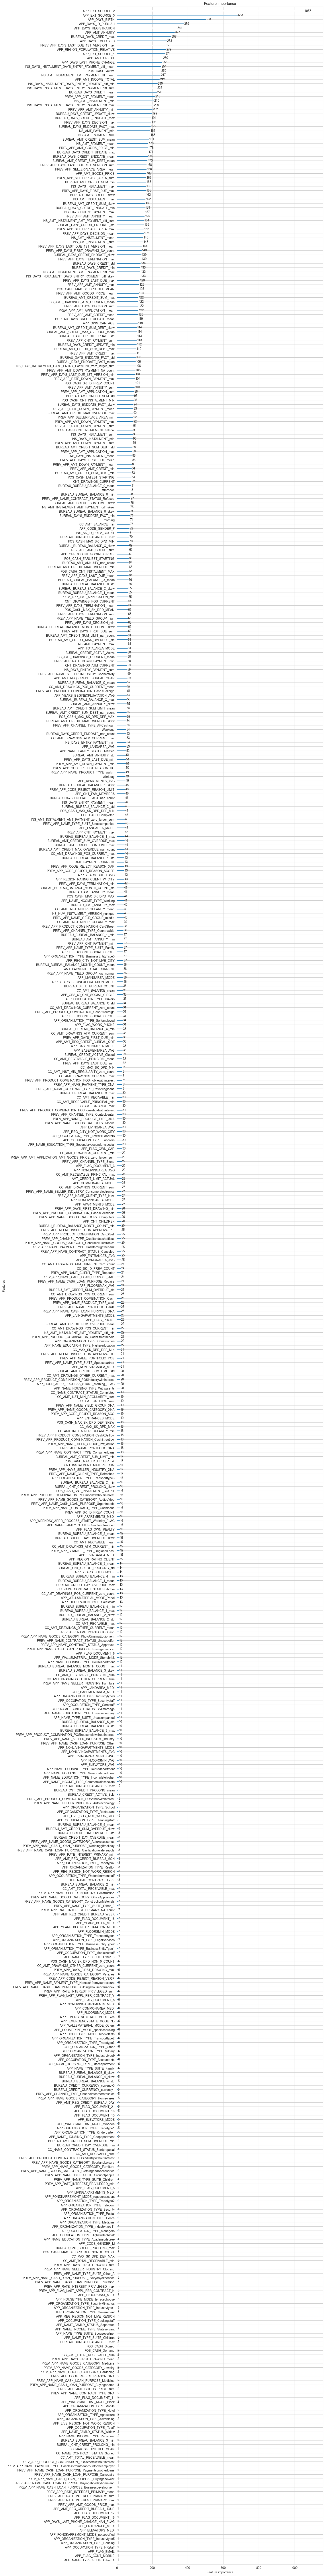

In [204]:
# plot feature importance
lgb.plot_importance(gbm, figsize=(12, 150))

In [205]:
# get insample performance
from sklearn.metrics import roc_auc_score
print('IN-sample',roc_auc_score(train['TARGET'],gbm.predict(train.drop('TARGET',axis=1))))

IN-sample 0.9494252053049559


In [206]:
# get outsample performance
print('OOS',roc_auc_score(test['TARGET'],gbm.predict(test.drop('TARGET',axis=1))))

OOS 0.7696663477979875


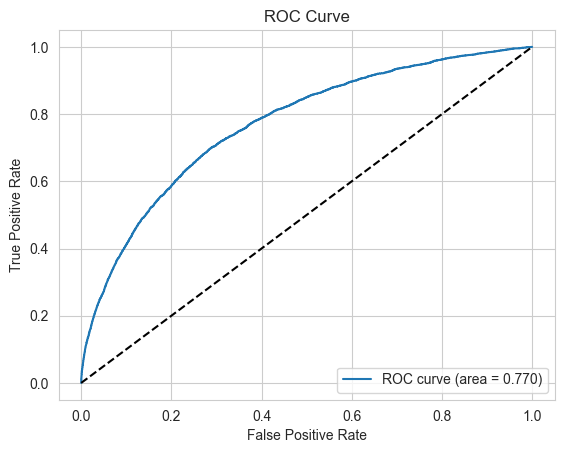

In [207]:
# plot ROC curve
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
fpr, tpr, thresholds = roc_curve(test['TARGET'],gbm.predict(test.drop('TARGET',axis=1)))
plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc_score(test['TARGET'],gbm.predict(test.drop('TARGET',axis=1))))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

## Using Pycaret to do a run through all different models

In [208]:
import pycaret